# **Tutorial 4**


## **Imports**

In [1]:
import numpy as np # arrays, array operations
import scipy.stats as stats # statistics
from google.colab import files
import matplotlib.pyplot as plt # plot graphs
import pandas as pd #dataframes
import io
import xarray as xr #multidimensional dataframes

In [2]:
#preliz
!pip install preliz

import preliz as pz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 7.0 MB/s eta 0:00:00


In [ ]:
#installs for reading the google sheets
!pip install --upgrade gspread
!pip install --upgrade oauth2client
!pip install --upgrade gspread google-auth oauth2client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 6.1.4
    Uninstalling gspread-6.1.4:
      Successfully uninstalled gspread-6.1.4


In [ ]:
#authentication
from google.colab import auth
from google.auth.transport.requests import Request
import gspread
from google.auth import default

# Authenticate the user
auth.authenticate_user()

# Get the credentials
creds, _ = default()

# Authorize gspread with the credentials
gc = gspread.authorize(creds)

In [ ]:
#getting our email collected data
# Open the spreadsheet by its ID
spreadsheet_id = '1N5I487HjDrl1Ep76ruVv0MvVpjL1cHRL6BBeHZU_9zg'  # Replace with your own spreadsheet ID
worksheet = gc.open_by_key(spreadsheet_id).sheet1

# Read all records into a DataFrame
data = worksheet.get_all_records()
df = pd.DataFrame(data)

# Display the DataFrame
df.head()

""


In [ ]:
data = df['How many emails do you receive each day?'].to_numpy()
print(data)

n = len(data)
print(f'There are {n} participants')

S = np.sum(data)
print(f'There are a total of {S} emails')

In [18]:
#simulate data
data = np.random.poisson(8, 24)
print(data)

n = len(data)
print(f'There are {n} participants')

S = np.sum(data)
print(f'There are a total of {S} emails')

[ 8  8 10  8  9 13 13  7  7  9  6 11  8  7  8  4  8 14  4  8  7  8 13 10]
There are 24 participants
There are a total of 208 emails


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

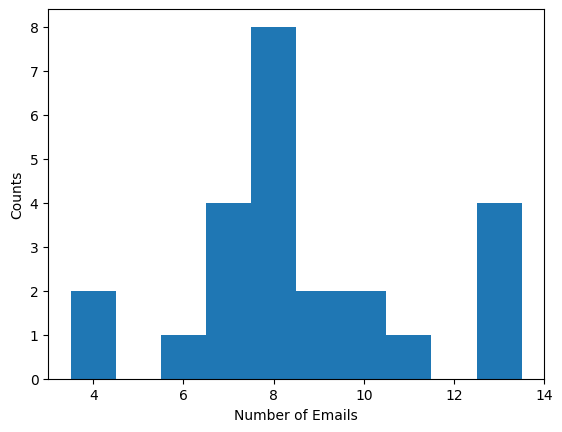

In [21]:
#look at the data
plt.hist(data, bins = 10, align = 'left')
plt.xlabel('Number of Emails')
plt.ylabel('Counts')
plt.savefig("data.png", bbox_inches='tight')
files.download("data.png")

## PyMC

In [22]:
import pymc as pm
import arviz as az

coords = {"data": np.arange(n)}

with pm.Model(coords = coords) as our_first_model:
    lambda_ = pm.Gamma('lam', alpha = 1.68, beta = 0.0569)
    k = pm.Poisson('k', mu = lambda_, observed=data, dims = 'data')
    idata = pm.sample(1000, chains = 4)

Output()

### Inference Data Object

In [23]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

**Posterior**

In [24]:
#we can save an xarray of the posterior information
posterior = idata.posterior.lam
posterior.shape #and see that the shape is 1000 draws for 4 chains

(4, 1000)

In [25]:
#we can also convert the information into a numpy array
posterior_np = posterior.to_numpy()
posterior_np

array([[10.00645525, 10.00645525,  9.5549192 , ...,  9.18762693,
         9.63390843,  7.76713761],
       [ 8.42097863,  8.95347487,  8.35207855, ...,  9.60691289,
         7.81470817,  7.89648499],
       [ 8.776303  ,  8.77337516,  8.41450683, ...,  9.02481972,
         9.54714213,  9.54714213],
       [ 9.21788394,  8.96518781,  9.55590165, ...,  8.75434422,
         8.6283525 ,  9.60079221]])

Analyzing the Posterior

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

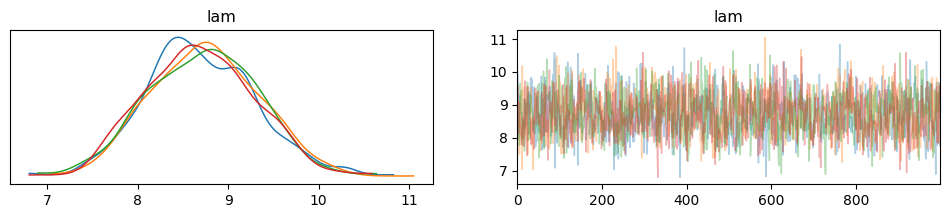

In [30]:
az.plot_trace(idata, compact = False)

plt.savefig("trace.png", bbox_inches='tight')
files.download("trace.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

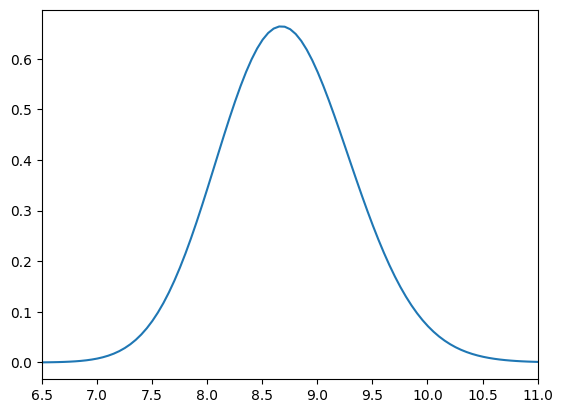

In [32]:
#comparing with our analytical results
alpha = 1.68
beta = 0.0569
x = np.linspace(0, 100, 2000)

posterior2 = pz.Gamma(alpha + S, beta + n).pdf(x)
plt.plot(x, posterior2)
plt.xlim([6.5, 11])

plt.savefig("posterior_analytical.png", bbox_inches='tight')
files.download("posterior_analytical.png")

Means of Chains

In [35]:
ms = idata.posterior.mean(dim = 'draw')
print(f'The means of the 4 chains are: {np.round(ms.lam.to_numpy(), 3)}')

The means of the 4 chains are: [8.702 8.755 8.722 8.685]


Effect of number of samples (draws)


Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The means of the 4 chains are: [8.707 8.729 8.705 8.731]


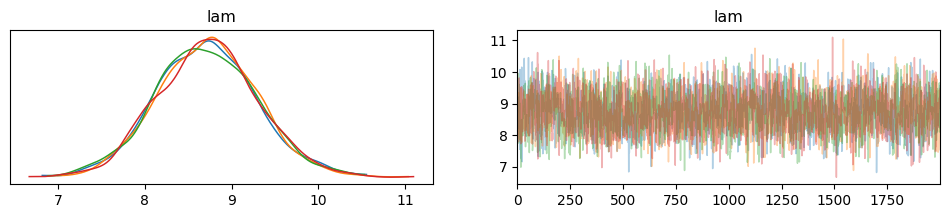

In [36]:
with pm.Model(coords = coords) as our_second_model:
    lambda_ = pm.Gamma('lam', alpha = 1.68, beta = 0.0569)
    k = pm.Poisson('k', mu = lambda_, observed=data, dims = 'data')
    idata2 = pm.sample(2000, chains = 4, random_seed=4591)

az.plot_trace(idata2, compact = False)

plt.savefig("trace2.png", bbox_inches='tight')
files.download("trace2.png")

ms = idata2.posterior.mean(dim = 'draw')
print(f'The means of the 4 chains are: {np.round(ms.lam.to_numpy(), 3)}')

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The means of the 4 chains are: [8.702 8.714 8.708 8.722]


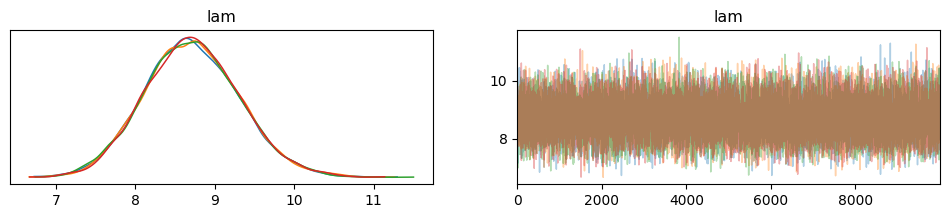

In [37]:
with pm.Model(coords = coords) as our_third_model:
    lambda_ = pm.Gamma('lam', alpha = 1.68, beta = 0.0569)
    k = pm.Poisson('k', mu = lambda_, observed=data, dims = 'data')
    idata3 = pm.sample(10000, chains = 4, random_seed=4591)

az.plot_trace(idata3, compact = False)

plt.savefig("trace3.png", bbox_inches='tight')
files.download("trace3.png")

ms = idata3.posterior.mean(dim = 'draw')
print(f'The means of the 4 chains are: {np.round(ms.lam.to_numpy(), 3)}')

In [ ]:
#for computing modes
def kde_mode(values):
    kde = stats.gaussian_kde(values)
    x = np.linspace(values.min(), values.max(), 1000)
    mode = x[np.argmax(kde(x))]
    return mode

mode_values = xr.apply_ufunc(
    lambda x: kde_mode(x),  # Apply KDE mode computation
    posterior,               # The xarray DataArray
    input_core_dims=[["draw"]],  # Compute mode along "draw"
    vectorize=True  # Ensure compatibility with multiple dimensions
)

print(mode_values)

<xarray.DataArray 'lam' (chain: 4)> Size: 32B
array([7.94007769, 7.87948982, 8.13397548, 7.95334308])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3


The total mean of the 4000 samples is: 8.095


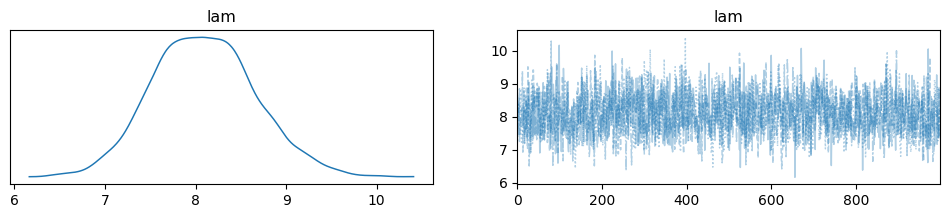

In [ ]:
#combining the 4 KDEs
az.plot_trace(idata, combined = True)

m = idata.posterior.mean()
print(f'The total mean of the 4000 samples is: {np.round(m.lam.to_numpy(), 3)}')

In [ ]:
#we can also get all the data as 4000 samples using extract, instead of as four seperate chains
az.extract(idata)

#if you specify number of samples, you get random sampling out of the 4000
az.extract(idata, num_samples = 3500)


<xarray.Dataset> Size: 112kB
Dimensions:  (sample: 3500)
Coordinates:
  * sample   (sample) object 28kB MultiIndex
  * chain    (sample) int64 28kB 2 1 2 0 1 1 2 0 1 0 2 ... 1 1 1 2 1 1 3 3 2 0 1
  * draw     (sample) int64 28kB 961 68 332 587 608 21 ... 843 208 289 484 635
Data variables:
    lam      (sample) float64 28kB 9.237 8.037 7.363 8.224 ... 7.18 8.934 7.618
Attributes:
    created_at:                 2025-03-16T06:57:21.398458+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1
    sampling_time:              14.114972352981567
    tuning_steps:               1000

HDI

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

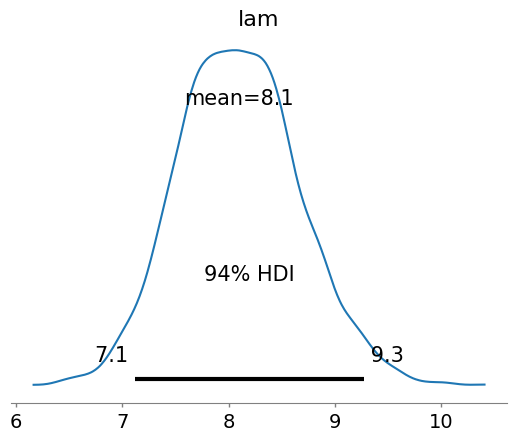

In [ ]:
#plotting the posterior with the HDI
az.plot_posterior(idata)


plt.savefig("hdi.png", bbox_inches='tight')
files.download("hdi.png")

In [ ]:
#and getting the values in a table
az.summary(idata, kind = 'stats').round(2)

,mean,sd,hdi_3%,hdi_97%
lam,8.1,0.57,7.12,9.27


<xarray.Dataset> Size: 128kB
Dimensions:  (sample: 4000)
Coordinates:
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    lam      (sample) float64 32kB 8.023 7.913 7.913 8.354 ... 7.987 7.354 7.701
Attributes:
    created_at:                 2025-03-16T06:57:21.398458+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1
    sampling_time:              14.114972352981567
    tuning_steps:               1000

Savage-Dickey Density Ratio

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

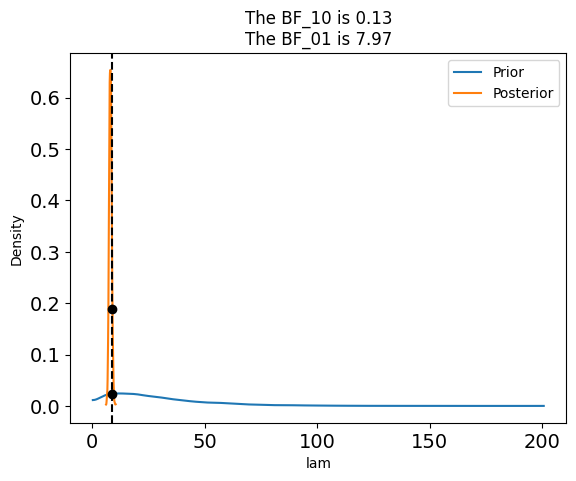

In [ ]:
az.plot_bf(idata, var_name="lam", prior = np.random.gamma(1.68, 1/0.0569, 10000), ref_val = 9)

plt.savefig("sd.png", bbox_inches='tight')
files.download("sd.png")

ROPE

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

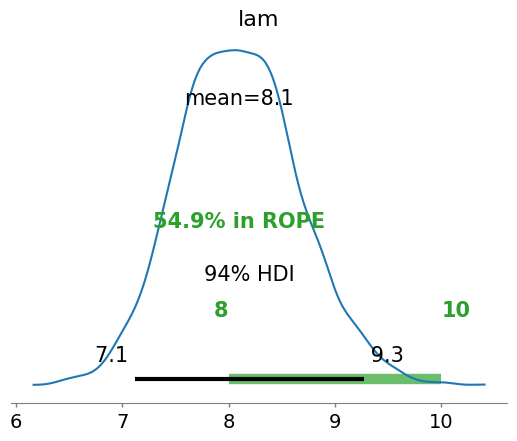

In [ ]:
az.plot_posterior(idata, rope=[8, 10])

plt.savefig("rope.png", bbox_inches='tight')
files.download("rope.png")

## PyTensor

Some of the following is taken from the PyMC notebook: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_pytensor.html

In [38]:
import pytensor
import pytensor.tensor as pt

To begin, we define some pytensor tensors and show how to perform some basic operations.



In [39]:
x = pt.scalar(name="x")
y = pt.vector(name="y")

print(
    f"""
x type: {x.type}
x name = {x.name}
---
y type: {y.type}
y name = {y.name}
"""
)


x type: Scalar(float64, shape=())
x name = x
---
y type: Vector(float64, shape=(?,))
y name = y



Now that we have defined the x and y tensors, we can create a new one by adding them together.



In [40]:
z = x + y
z.name = "x + y"
print(f'z type: {z.type}\nz name = {z.name}')


z type: Vector(float64, shape=(?,))
z name = x + y


To make the computation a bit more complex let us take the logarithm of the resulting tensor.



In [41]:
w = pt.log(z)
w.name = "log(x + y)"

We can use the dprint() function to print the computational graph of any given tensor.



In [42]:
pytensor.dprint(w)


Log [id A] 'log(x + y)'
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ x [id D]
    └─ y [id E]


Note that this graph does not do any computation (yet!). It is simply defining the sequence of steps to be done. We can use function() to define a callable object so that we can push values trough the graph.

In [43]:
f = pytensor.function(inputs=[x, y], outputs=w)
pytensor.dprint(f)


Composite{log((i0 + i1))} [id A] 'log(x + y)' 1
 ├─ ExpandDims{axis=0} [id B] 0
 │  └─ x [id C]
 └─ y [id D]

Inner graphs:

Composite{log((i0 + i1))} [id A]
 ← log [id E] 'o0'
    └─ add [id F]
       ├─ i0 [id G]
       └─ i1 [id H]


Now that the graph is compiled, we can push some concrete values:



In [44]:
f(x=0, y=[1, np.e])


array([0., 1.])

One of the most important features of pytensor is that it can automatically optimize the mathematical operations inside a graph. Let’s consider a simple example:

In [45]:
a = pt.scalar(name="a")
b = pt.scalar(name="b")

c = a / b
c.name = "a / b"

pytensor.dprint(c)

True_div [id A] 'a / b'
 ├─ a [id B]
 └─ b [id C]


Now let us multiply b times c. This should result in simply a.



In [46]:
d = b * c
d.name = "b * c"

pytensor.dprint(d)

Mul [id A] 'b * c'
 ├─ b [id B]
 └─ True_div [id C] 'a / b'
    ├─ a [id D]
    └─ b [id B]


The graph shows the full computation, but once we compile it the operation becomes the identity on a as expected.

In [ ]:
g = pytensor.function(inputs=[a, b], outputs=d)

pytensor.dprint(g)

DeepCopyOp [id A] 0
 └─ a [id B]


Random variables in PyTensor

In [47]:
y = pt.random.normal(loc=0, scale=1, name="y")
y.type

TensorType(float64, shape=())

In [48]:
#look at the graph
pytensor.dprint(y)


normal_rv{"(),()->()"}.1 [id A] 'y'
 ├─ RNG(<Generator(PCG64) at 0x7B982FBC9380>) [id B]
 ├─ NoneConst{None} [id C]
 ├─ 0 [id D]
 └─ 1 [id E]


We could sample by calling eval(). on the random variable.



In [49]:
for i in range(10):
    print(f"Sample {i}: {y.eval()}")

Sample 0: 0.02452613021739706
Sample 1: 0.02452613021739706
Sample 2: 0.02452613021739706
Sample 3: 0.02452613021739706
Sample 4: 0.02452613021739706
Sample 5: 0.02452613021739706
Sample 6: 0.02452613021739706
Sample 7: 0.02452613021739706
Sample 8: 0.02452613021739706
Sample 9: 0.02452613021739706


We always get the same samples! This has to do with the random seed step in the graph, i.e. RandomGeneratorSharedVariable. We will show how to generate different samples with pymc below.

To do so, we start by defining a pymc normal distribution.

In [50]:
x = pm.Normal.dist(mu=0, sigma=1)
pytensor.dprint(x)

normal_rv{"(),()->()"}.1 [id A]
 ├─ RNG(<Generator(PCG64) at 0x7B9830F57AE0>) [id B]
 ├─ NoneConst{None} [id C]
 ├─ 0 [id D]
 └─ 1 [id E]


In [51]:
for i in range(10):
    print(f"Sample {i}: {x.eval()}")

Sample 0: -1.5125308035290568
Sample 1: -1.5125308035290568
Sample 2: -1.5125308035290568
Sample 3: -1.5125308035290568
Sample 4: -1.5125308035290568
Sample 5: -1.5125308035290568
Sample 6: -1.5125308035290568
Sample 7: -1.5125308035290568
Sample 8: -1.5125308035290568
Sample 9: -1.5125308035290568


As before we get the same value for all iterations. The correct way to generate random samples is using draw().

[Text(0.5, 1.0, 'Samples from a normal distribution using pymc'),
 Text(0, 0.5, 'count')]

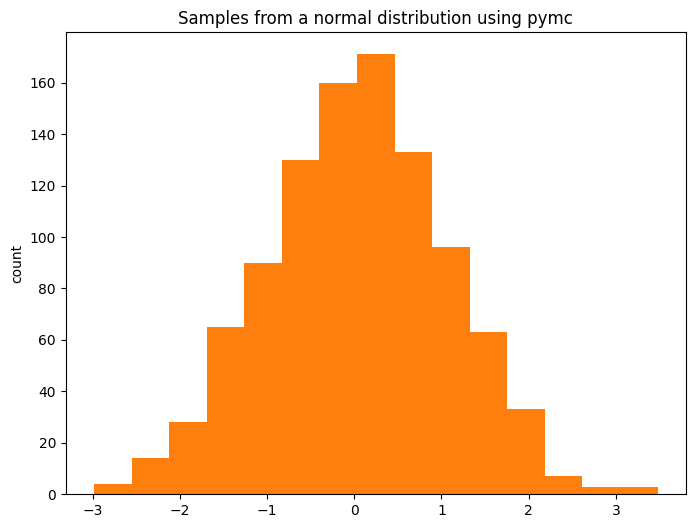

In [52]:
#and plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(pm.draw(x, draws=1_000), color="C1", bins=15)
ax.set(title="Samples from a normal distribution using pymc", ylabel="count")

### What is going on behind the scenes?

We can now look into how this is done inside a Model.



In [59]:
with pm.Model() as model:
    z = pm.Normal(name="z", mu=0, sigma=1)

pytensor.dprint(z)

normal_rv{"(),()->()"}.1 [id A] 'z'
 ├─ RNG(<Generator(PCG64) at 0x7B98395C7D80>) [id B]
 ├─ NoneConst{None} [id C]
 ├─ 0 [id D]
 └─ 1 [id E]


We are just creating random variables like we saw before, but now registering them in a pymc model. To extract the list of random variables we can simply do:

In [65]:
pytensor.dprint(model.basic_RVs)


normal_rv{"(),()->()"}.1 [id A] 'z'
 ├─ RNG(<Generator(PCG64) at 0x7B9839E444A0>) [id B]
 ├─ NoneConst{None} [id C]
 ├─ 0 [id D]
 └─ 1 [id E]


In [61]:
for i in range(10):
    print(f"Sample {i}: {pm.draw(z)}")

Sample 0: -0.3483973505185665
Sample 1: -0.5008751446459089
Sample 2: 0.6346815275416208
Sample 3: -1.895722953727876
Sample 4: 1.808543499071056
Sample 5: 1.4326239770045126
Sample 6: 1.2973205476415
Sample 7: 0.6388387934212152
Sample 8: -0.10503359930171786
Sample 9: 0.942501775338231


### Log Probabilities
(these are often used to help achieve numeric stability in the sampling algorithms)

pymc is able to convert RandomVariables to their respective probability functions. One simple way is to use logp(), which takes as first input a RandomVariable, and as second input the value at which the logp is evaluated.

In [67]:
z_value = pt.vector(name="z")
z_logp = pm.logp(rv=z, value=z_value)

pytensor.dprint(z_logp)


Check{sigma > 0} [id A] 'z_logprob'
 ├─ Sub [id B]
 │  ├─ Sub [id C]
 │  │  ├─ Mul [id D]
 │  │  │  ├─ ExpandDims{axis=0} [id E]
 │  │  │  │  └─ -0.5 [id F]
 │  │  │  └─ Pow [id G]
 │  │  │     ├─ True_div [id H]
 │  │  │     │  ├─ Sub [id I]
 │  │  │     │  │  ├─ z [id J]
 │  │  │     │  │  └─ ExpandDims{axis=0} [id K]
 │  │  │     │  │     └─ 0 [id L]
 │  │  │     │  └─ ExpandDims{axis=0} [id M]
 │  │  │     │     └─ 1 [id N]
 │  │  │     └─ ExpandDims{axis=0} [id O]
 │  │  │        └─ 2 [id P]
 │  │  └─ ExpandDims{axis=0} [id Q]
 │  │     └─ Log [id R]
 │  │        └─ Sqrt [id S]
 │  │           └─ 6.283185307179586 [id T]
 │  └─ ExpandDims{axis=0} [id U]
 │     └─ Log [id V]
 │        └─ 1 [id N]
 └─ All{axes=None} [id W]
    └─ MakeVector{dtype='bool'} [id X]
       └─ All{axes=None} [id Y]
          └─ Gt [id Z]
             ├─ 1 [id N]
             └─ 0 [id BA]


Observe that, as explained at the beginning, there has been no computation yet. The actual computation is performed after compiling and passing the input. For illustration purposes alone, we will again use the handy eval() method.

In [70]:
z_logp.eval({z_value: [0]})


array([-0.91893853])

This is nothing else than evaluating the log probability of a normal distribution.



### Derivatives and Gradients

In [71]:
x = pt.scalar('x')        # Symbolic scalar input
f = x**2                  # Define the function f(x) = x^2

pytensor.dprint(f)


Pow [id A]
 ├─ x [id B]
 └─ 2 [id C]


Compute the derivative

In [72]:
df_dx = pytensor.grad(f, x)   # Compute derivative df/dx
pytensor.dprint(df_dx)


Mul [id A]
 ├─ Mul [id B]
 │  ├─ Second [id C]
 │  │  ├─ Pow [id D]
 │  │  │  ├─ x [id E]
 │  │  │  └─ 2 [id F]
 │  │  └─ 1.0 [id G]
 │  └─ 2 [id F]
 └─ Pow [id H]
    ├─ x [id E]
    └─ Sub [id I]
       ├─ 2 [id F]
       └─ DimShuffle{order=[]} [id J]
          └─ 1 [id K]


We can evaluate for specific values

In [74]:
f_func = pytensor.function([x], f)
df_func = pytensor.function([x], df_dx)

print(f_func(3))     # Output: 9
print(df_func(3))    # Output: 6 (gradient at x=3)

9.0
6.0


A more complex function

In [ ]:
x = pt.scalar('x')
y = x**2
z = pt.sin(y)


dz_dx = pytensor.grad(z, x)

from pytensor.printing import debugprint
debugprint(dz_dx)

z_func = pytensor.function([x], z)
dzdx_func = pytensor.function([x], dz_dx)

print(z_func(2))       # sin(4)
print(dzdx_func(2))    # derivative using chain rule: cos(4)*2x = cos(4)*4

Mul [id A]
 ├─ Mul [id B]
 │  ├─ Mul [id C]
 │  │  ├─ Second [id D]
 │  │  │  ├─ Sin [id E]
 │  │  │  │  └─ Pow [id F]
 │  │  │  │     ├─ x [id G]
 │  │  │  │     └─ 2 [id H]
 │  │  │  └─ 1.0 [id I]
 │  │  └─ Cos [id J]
 │  │     └─ Pow [id F]
 │  │        └─ ···
 │  └─ 2 [id H]
 └─ Pow [id K]
    ├─ x [id G]
    └─ Sub [id L]
       ├─ 2 [id H]
       └─ DimShuffle{order=[]} [id M]
          └─ 1 [id N]
-0.7568024953079282
-2.6145744834544478
